In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [27]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from scipy.stats import randint

In [14]:
from columnas import *

In [15]:
kepler = pd.read_csv('datasets/keplern.csv')
tess = pd.read_csv('datasets/tessn.csv')
k2 = pd.read_csv('datasets/k2n.csv')

In [16]:
combined = pd.concat([kepler, tess, k2])

In [17]:
combined_no_candidates = combined.query('category != \'CANDIDATE\'')
combined_candidates = combined.query('category == \'CANDIDATE\'')

In [18]:
df = combined_no_candidates

# Encode label
le = LabelEncoder()
df['category'] = le.fit_transform(df['category'])

# Split features (X) and labels (y)
features = [
    'transit_period',
    'transit_duration',
    'transit_depth',
    'planet_radius',
    'star_temperature',
    'star_radius',
    'star_surface_gravity',
    'star_brightness'
]

X = df[features]
y = df['category']

# Split training and test data 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

C:\Users\ferlr\AppData\Local\Temp\ipykernel_19940\2353862780.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['category'] = le.fit_transform(df['category'])


In [ ]:
df['category'].value_count()

In [ ]:
# ==========================================
# 2️⃣ Definir el modelo base
# ==========================================
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# ==========================================
# 3️⃣ Espacio de búsqueda de hiperparámetros
# ==========================================
param_dist = {
    'n_estimators': randint(100, 500),      # número de árboles
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2', None], # cómo elegir features por árbol
    'bootstrap': [True, False]
}

# ==========================================
# 4️⃣ Ejecutar búsqueda aleatoria
# ==========================================
search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,                  # prueba 50 combinaciones aleatorias
    cv=5,                       # validación cruzada 5-fold
    scoring='f1',               # puedes usar 'accuracy', 'recall', 'f1'
    verbose=2,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)

# ==========================================
# 5️⃣ Resultados de la búsqueda
# ==========================================
print("✅ Mejores hiperparámetros encontrados:")
print(search.best_params_)

best_rf = search.best_estimator_

# ==========================================
# 6️⃣ Evaluar en el conjunto de prueba
# ==========================================
y_pred = best_rf.predict(X_test)
print("\n🌳 Random Forest (Optimizado)")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [23]:
# Train the model
rf = RandomForestClassifier(
    n_estimators=100,        # trees
    max_depth=None,          # depth limit
    min_samples_split=2,     # minimum samples to divide a node
    random_state=42,         # seed
    n_jobs=-1,               # use all cpu cores
    class_weight='balanced'  
)
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [24]:
# Evaluate thhe model
y_pred = rf.predict(X_test)

print("🌳 Random Forest Results")
print(classification_report(y_test, y_pred, target_names=le.classes_))


🌳 Random Forest Results
                precision    recall  f1-score   support

     CONFIRMED       0.87      0.92      0.89      1052
FALSE POSITIVE       0.92      0.88      0.90      1206

      accuracy                           0.90      2258
     macro avg       0.90      0.90      0.90      2258
  weighted avg       0.90      0.90      0.90      2258



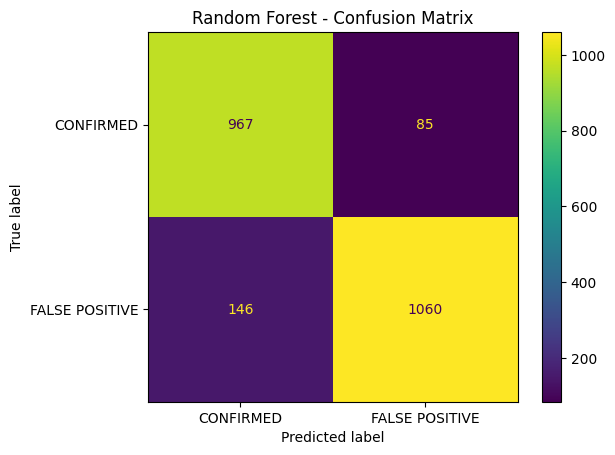

In [21]:
# Confusion matrix
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, display_labels=le.classes_)
plt.title("Random Forest - Confusion Matrix")
plt.show()

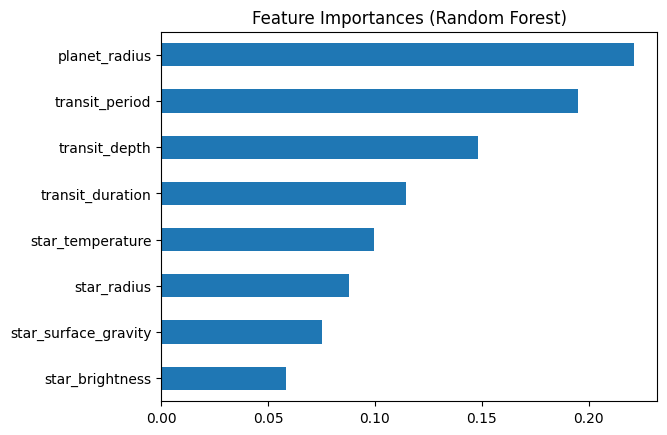

In [25]:
# Feature importance
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)

importances.plot(kind='barh', title='Feature Importances (Random Forest)')
plt.gca().invert_yaxis()
plt.show()